# ARIMA Model Selection

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.signal import periodogram
import warnings

from sklearn.metrics import mean_squared_error

# Load the dataset
file_path = "/Users/alonclausen/Desktop/Studie/Kandidat/Seminar/SEMINARFIN/fulldata.csv"
data = pd.read_csv(file_path)

# Display the first few rows to understand the structure
data.head()


,SpotPriceDKK,from,to,mean_temp_Aabenraa,mean_temp_Aalborg,mean_temp_Aarhus,mean_temp_Assens,mean_temp_Billund,mean_temp_Brønderslev,mean_temp_Esbjerg,...,wind_dir_W_Syddjurs,wind_dir_W_Sønderborg,wind_dir_W_Thisted,wind_dir_W_Tønder,wind_dir_W_Varde,wind_dir_W_Vejen,wind_dir_W_Vejle,wind_dir_W_Vesthimmerlands,wind_dir_W_Viborg,wind_dir_W_Ærø
0,291.329987,2024-10-20 05:00:00+00:00,2024-10-20 06:00:00+00:00,12.3,11.9,11.9,12.2,12.4,11.7,12.4,...,False,False,False,False,False,False,False,False,False,False
1,240.389999,2024-10-20 04:00:00+00:00,2024-10-20 05:00:00+00:00,12.4,11.7,11.9,12.4,12.4,11.4,12.4,...,False,False,False,False,False,False,False,False,False,False
2,241.880005,2024-10-20 03:00:00+00:00,2024-10-20 04:00:00+00:00,12.5,11.4,11.9,12.5,12.3,11.3,12.4,...,False,False,False,False,False,False,False,False,False,False
3,444.450012,2024-10-20 02:00:00+00:00,2024-10-20 03:00:00+00:00,12.4,11.4,11.6,12.5,12.0,11.5,12.4,...,False,False,False,False,False,False,False,False,False,False
4,417.000000,2024-10-20 01:00:00+00:00,2024-10-20 02:00:00+00:00,12.4,11.8,11.2,12.4,11.7,12.1,12.3,...,False,False,False,False,False,False,False,False,False,False


## ARIMA Model Parameter Selection

To determine the best parameters for an ARIMA model using only the `SpotPriceDKK` column, we will follow these steps:

1. **Data Preparation**: Extract the `SpotPriceDKK` column and ensure it is in the correct format for time series analysis.
2. **Stationarity Check**: Perform the Augmented Dickey-Fuller (ADF) test to check if the series is stationary.
3. **ACF and PACF Plots**: Plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) to identify potential values for the ARIMA parameters (p, d, q).
4. **Model Selection**: Fit ARIMA models with different combinations of parameters and select the best model based on criteria such as AIC (Akaike Information Criterion).

Let's start with the data preparation and stationarity check.
```

In [2]:
# Extract the 'SpotPriceDKK' column
spot_price = data['SpotPriceDKK']

# Print the column names to check for the correct datetime column
print(data.columns)

# Ensure the 'from' column is in datetime format
data['from'] = pd.to_datetime(data['from'])

# Set the 'from' column as the index of the spot_price series
spot_price.index = data['from']

# Display the first few rows to verify the changes
spot_price.head()

Index(['SpotPriceDKK', 'from', 'to', 'mean_temp_Aabenraa', 'mean_temp_Aalborg',
       'mean_temp_Aarhus', 'mean_temp_Assens', 'mean_temp_Billund',
       'mean_temp_Brønderslev', 'mean_temp_Esbjerg',
       ...
       'wind_dir_W_Syddjurs', 'wind_dir_W_Sønderborg', 'wind_dir_W_Thisted',
       'wind_dir_W_Tønder', 'wind_dir_W_Varde', 'wind_dir_W_Vejen',
       'wind_dir_W_Vejle', 'wind_dir_W_Vesthimmerlands', 'wind_dir_W_Viborg',
       'wind_dir_W_Ærø'],
      dtype='object', length=471)


from
2024-10-20 05:00:00+00:00    291.329987
2024-10-20 04:00:00+00:00    240.389999
2024-10-20 03:00:00+00:00    241.880005
2024-10-20 02:00:00+00:00    444.450012
2024-10-20 01:00:00+00:00    417.000000
Name: SpotPriceDKK, dtype: float64

In [ ]:
# Perform the Augmented Dickey-Fuller test
adf_test_diff = adfuller(spot_price)

# Extract and display the test results
adf_result_diff = pd.Series(adf_test_diff[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_test_diff[4].items():
    adf_result_diff[f'Critical Value ({key})'] = value

print(adf_result_diff)

Test Statistic                -9.430826e+00
p-value                        5.195796e-16
#Lags Used                     7.100000e+01
Number of Observations Used    1.209190e+05
Critical Value (1%)           -3.430404e+00
Critical Value (5%)           -2.861564e+00
Critical Value (10%)          -2.566783e+00
dtype: float64


#### We can see that our data is already stationary and there is no reason to differentiate further

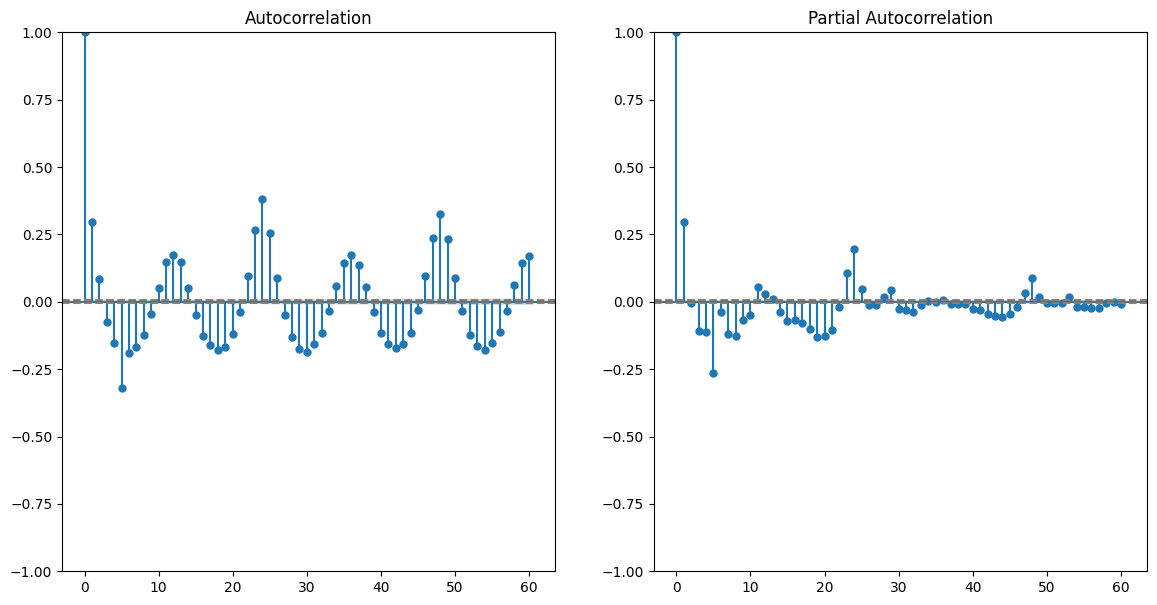

In [9]:
# Calculate the confidence intervals for ACF and PACF
conf_acf = 1.96 / (len(spot_price) ** 0.5)
conf_pacf = 1.96 / (len(spot_price) ** 0.5)

# Plot ACF with confidence intervals
plt.figure(figsize=(14, 7))
plt.subplot(121)
plot_acf(spot_price_diff, ax=plt.gca(), lags=60)
plt.axhline(y=conf_acf, linestyle='--', color='gray')
plt.axhline(y=-conf_acf, linestyle='--', color='gray')

# Plot PACF with confidence intervals
plt.subplot(122)
plot_pacf(spot_price_diff, ax=plt.gca(), lags=60)
plt.axhline(y=conf_pacf, linestyle='--', color='gray')
plt.axhline(y=-conf_pacf, linestyle='--', color='gray')

plt.show()

In [11]:
auto_arima_model = pm.auto_arima(
    spot_price[:1000],  # Use the first 1000 rows
    seasonal=True,
    m=24,
    trace=True,
    suppress_warnings=True
)

# Display the summary of the model
print(auto_arima_model.summary())




Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=3.54 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=14384.039, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=12513.943, Time=0.99 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=13166.905, Time=1.21 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=15635.841, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=12824.517, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=12434.093, Time=6.19 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=11.21 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=2.19 sec
 ARIMA(0,0,0)(2,0,0)[24] intercept   : AIC=14187.703, Time=2.16 sec
 ARIMA(2,0,0)(2,0,0)[24] intercept   : AIC=12350.454, Time=8.30 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=12402.205, Time=1.48 sec
 ARIMA(2,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=7.96 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=2.76 sec
 ARIMA(3,0,0)(2,0,0)[24] intercept

In [12]:
auto_arima_model = pm.auto_arima(
    spot_price[:5000],  # Use the first 5000 rows
    seasonal=True,
    m=24,
    trace=True,
    suppress_warnings=True,
    d=0  # No differencing
)

# Display the summary of the model
print(auto_arima_model.summary())



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=16.73 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=72047.233, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=61704.254, Time=5.13 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=65734.401, Time=5.96 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=77862.936, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=63529.963, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=61347.970, Time=37.38 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=60.36 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=9.91 sec
 ARIMA(0,0,0)(2,0,0)[24] intercept   : AIC=69979.795, Time=12.57 sec
 ARIMA(2,0,0)(2,0,0)[24] intercept   : AIC=61071.032, Time=44.45 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=61340.071, Time=8.57 sec
 ARIMA(2,0,0)(2,0,1)[24] intercept   : AIC=61289.923, Time=61.75 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=12.05 sec
 ARIMA(3,0,0)(2,0,0)[2

/var/folders/jg/p6c6lqr91kj2q41htjb2tvsc0000gn/T/ipykernel_27648/947397560.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=forecast_start, periods=24, freq='H')
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1h will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency -1h will be used.
  self._init_dates(d

Forecasted values for Day 2:
2024-08-01 01:00:00     674.708140
2024-08-01 02:00:00     702.448473
2024-08-01 03:00:00     741.586389
2024-08-01 04:00:00     807.439934
2024-08-01 05:00:00     915.305739
2024-08-01 06:00:00    1127.396927
2024-08-01 07:00:00     995.281741
2024-08-01 08:00:00     761.167085
2024-08-01 09:00:00     583.465927
2024-08-01 10:00:00     401.002191
2024-08-01 11:00:00     304.504801
2024-08-01 12:00:00     245.651352
2024-08-01 13:00:00     242.134740
2024-08-01 14:00:00     291.336954
2024-08-01 15:00:00     341.880403
2024-08-01 16:00:00     431.764156
2024-08-01 17:00:00     567.514086
2024-08-01 18:00:00     700.656060
2024-08-01 19:00:00     759.028606
2024-08-01 20:00:00     724.252096
2024-08-01 21:00:00     605.124792
2024-08-01 22:00:00     544.787024
2024-08-01 23:00:00     540.513956
2024-08-02 00:00:00     561.083474
Freq: h, Name: predicted_mean, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


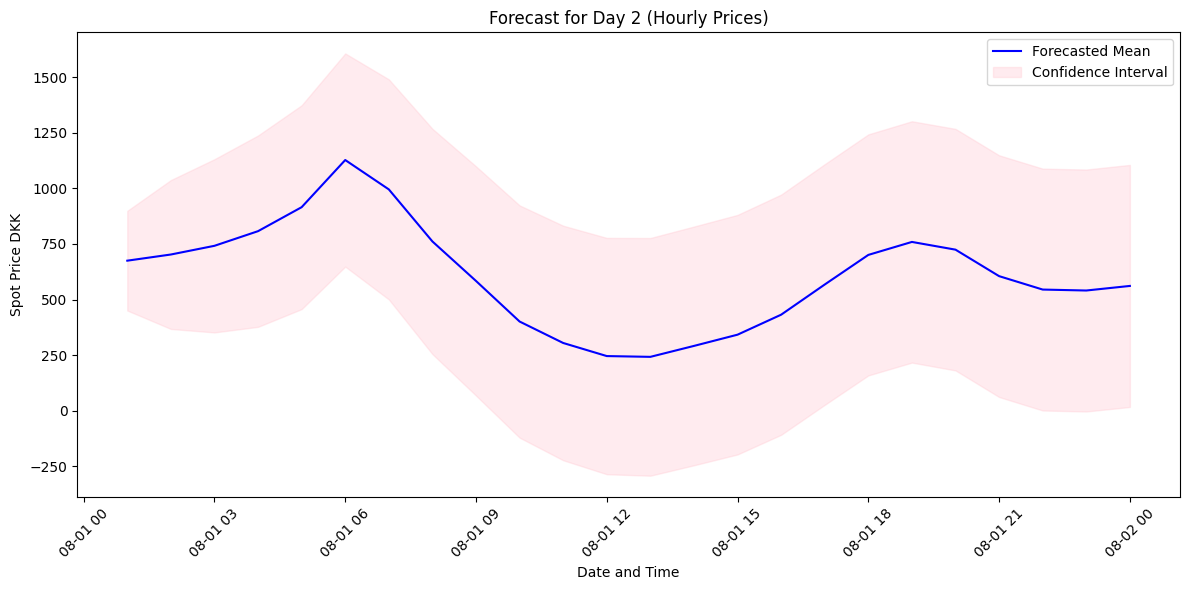

In [17]:
# Ensure the index is a DatetimeIndex and timezone-naive
spot_price.index = pd.to_datetime(spot_price.index).tz_localize(None)

# Define the current time (1 PM on Day 1) and make it timezone-naive
current_time = pd.Timestamp('2024-07-31 13:00:00').tz_localize(None)

# Use all data up to the end of Day 1 (midnight)
end_of_day_1 = current_time + pd.Timedelta(hours=11)  # Midnight of Day 2
data_up_to_day_1 = spot_price[:end_of_day_1]

# Define the forecast horizon (24 hours for Day 2)
forecast_start = end_of_day_1 + pd.Timedelta(hours=1)  # 1st hour of Day 2
forecast_index = pd.date_range(start=forecast_start, periods=24, freq='H')

# Train the SARIMAX model on data up to the end of Day 1
sarimax_model = SARIMAX(data_up_to_day_1, order=(2, 0, 1), seasonal_order=(2, 0, 1, 24))
sarimax_results = sarimax_model.fit(disp=False)

# Generate a 24-hour forecast
forecast = sarimax_results.get_forecast(steps=24)
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Align the forecasted values with the correct timestamps
predicted_mean.index = forecast_index
conf_int.index = forecast_index

# Print the forecasted values
print("Forecasted values for Day 2:")
print(predicted_mean)

# Plot the forecasted values with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(predicted_mean.index, predicted_mean, label='Forecasted Mean', color='blue')
plt.fill_between(predicted_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.title('Forecast for Day 2 (Hourly Prices)')
plt.xlabel('Date and Time')
plt.ylabel('Spot Price DKK')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


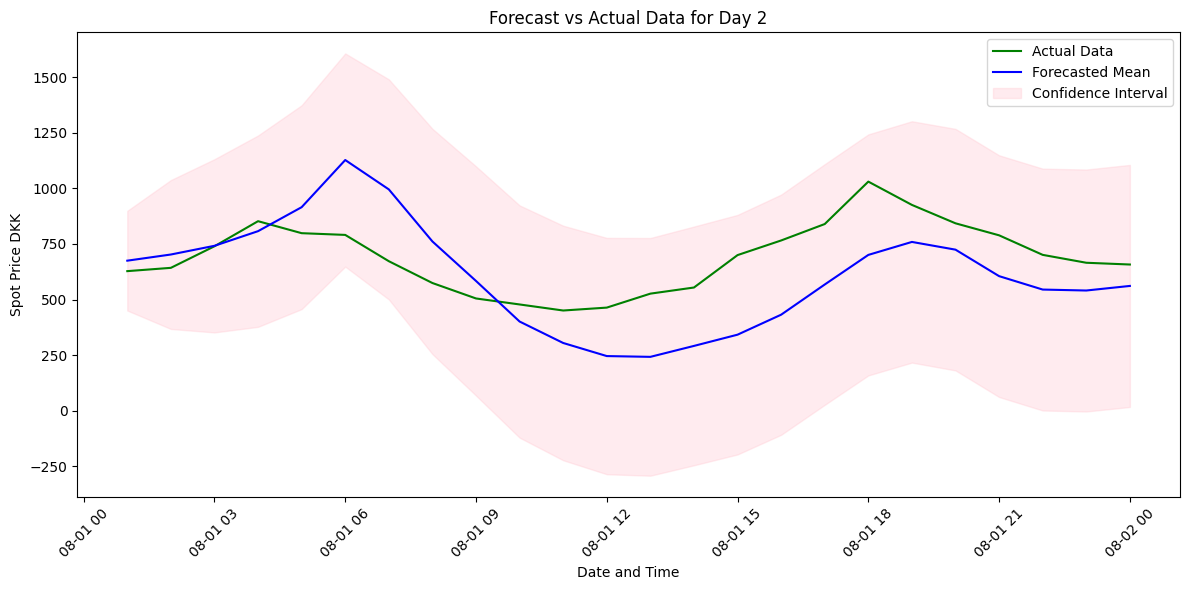

In [18]:
# Define actual data for Day 2 (the true observed values for comparison)
actual_data_day_2 = spot_price[forecast_index]

# Plot the forecasted vs actual data
plt.figure(figsize=(12, 6))
plt.plot(actual_data_day_2.index, actual_data_day_2, label='Actual Data', color='green')
plt.plot(predicted_mean.index, predicted_mean, label='Forecasted Mean', color='blue')
plt.fill_between(predicted_mean.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
plt.title('Forecast vs Actual Data for Day 2')
plt.xlabel('Date and Time')
plt.ylabel('Spot Price DKK')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
